In [1]:
import sys,os
import numpy as np
import pydicom as dcm
import matplotlib.pyplot as plt

## Using functions from longiDICOM

In [2]:
# loading functions from modules (from another location, might need to do ../longiDICOM/code, or something
sys.path.append('../code')
from RD_tools import find_dose_file, get_dose_in_gy, get_dose_xyz, get_dose_spacing, resample_dose_map_3D, resize_dose_map_3D, get_struct_dose_values, create_binary_mask, extract_dose_values
from rs_tools import find_RS_file, find_ROI_names

# Basic RD and CT Loading

In [3]:
path_to_ct = '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/19/20180411_CT_09_APR_2018/'

# Load CT:
slices = [dcm.read_file(path_to_ct+ s) for s in os.listdir(path_to_ct) if 'CT' in s]
slices.sort(key = lambda x: (x.InstanceNumber))

# Image Sacping Parameters
CT_origin = slices[0].ImagePositionPatient

pixel_spacing = slices[0].PixelSpacing

CT_spacing = [pixel_spacing[0],pixel_spacing[1],slices[0].SliceThickness]

In [4]:
# LOAD RD
RD = find_dose_file(path_to_ct)
# Note, the pixel array is not in gray, you have to scale it
dose_gy = get_dose_in_gy(RD)
# At this point, it is still not the same size as the CT


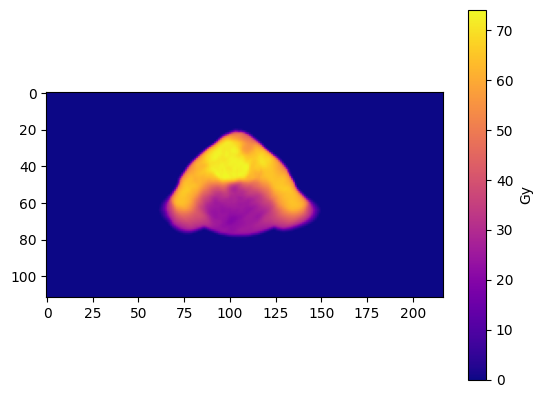

In [5]:
plt.imshow(dose_gy[50],cmap=plt.cm.plasma)
plt.colorbar(label="Gy")

# Resampling and Sizing Dose Maps in CT Space

### Resample - make same spacing as CT

In [6]:
dose_spacing = get_dose_spacing(RD)
print("Dose Spacing:",dose_spacing)
print("CT Spacing:",CT_spacing)

Dose Spacing: ['2.5', '2.5', 3.0]
CT Spacing: ['1.1640625', '1.1640625', '3.0']


In [7]:
resampled_dose_map =  resample_dose_map_3D(dose_gy,CT_spacing, dose_spacing)

OG SIZE [112 217 132]
NEW SIZE [132, 241, 466]
scaling factors [2.1476510067114094, 2.1476510067114094, 1.0]
[240.53691275 466.04026846 132.        ]
(132, 241, 466)


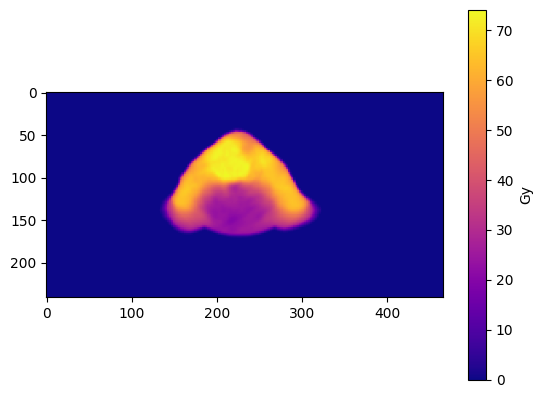

In [8]:
plt.imshow(resampled_dose_map[50],cmap=plt.cm.plasma)
plt.colorbar(label="Gy")

In [9]:
# now it's the right spacing, but not the right size
print("Dose Size:", resampled_dose_map.shape)
print("CT Size:", len(slices),len(slices[0].pixel_array[0]), len(slices[0].pixel_array))

Dose Size: (132, 241, 466)
CT Size: 139 512 512


## Resize - make same size as CT

In [10]:
CT_shape = [len(slices[0].pixel_array),len(slices[0].pixel_array[0]), len(slices)]

In [11]:
resized_dose_map = resize_dose_map_3D(resampled_dose_map,CT_shape,CT_spacing, RD.ImagePositionPatient,CT_origin)

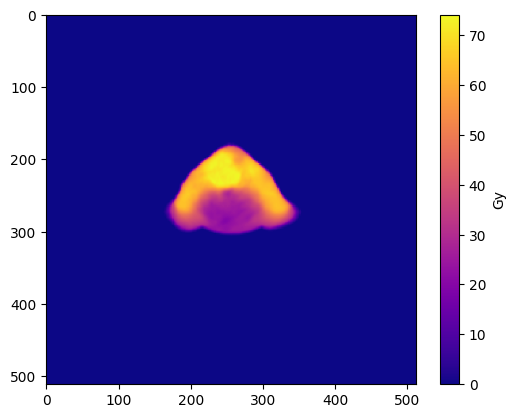

In [12]:
plt.imshow(resized_dose_map[50],cmap=plt.cm.plasma)
plt.colorbar(label="Gy")


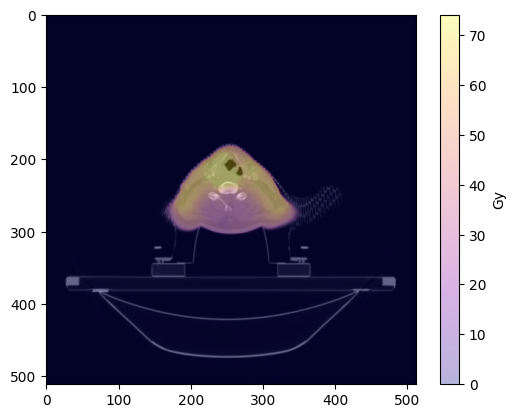

In [30]:
# Verify with CT
plt.imshow(slices[50].pixel_array,cmap='gray')
plt.imshow(resized_dose_map[50],cmap=plt.cm.plasma,alpha=.3)
plt.colorbar(label="Gy")

In [14]:
# now it's the right spacing, but not the right size
print("Dose Size:", resized_dose_map.shape)
print("CT Size:", len(slices),len(slices[0].pixel_array[0]), len(slices[0].pixel_array))

Dose Size: (139, 512, 512)
CT Size: 139 512 512


# Getting dose information for structures

In [15]:
# Using RD and CT loaded from before
RS = dcm.read_file(os.path.join(path_to_ct,find_RS_file(path_to_ct)))

# Check which names are available in the RT Struct given a keyword
names = find_ROI_names(RS, 'parotid')
print("Structure names with keyword 'parotid':",names)

Structure names with keyword 'parotid': ['Parotid_L', 'Parotid_R']


In [25]:
parotid_R_dose_values = get_struct_dose_values(RS, RD, 'Parotid_R') 

# Calculate dose metrics
mean_dose = np.mean(parotid_R_dose_values)
max_dose = np.max(parotid_R_dose_values)

print(f"Mean Dose: {mean_dose} Gy")
print(f"Max Dose: {max_dose} Gy")


Mean Dose: 43.87166871856362 Gy
Max Dose: 73.90240765610174 Gy


### Here are the functions that get_struct_dose_values calls to see under the hood

In [21]:
# UNDER THE HOOD OF THE FN ABOVE 
# These functions were adapted from Haley's rtdsm code, need to be double checked
xpos,ypos,zpos = get_dose_xyz(RD)

# this makes the structs into the dose map shape/size, rather than moving the dose to image space like we did earlier
mask_struct = create_binary_mask(RS,RD,'Parotid_R',xpos,ypos,zpos)
print("Shape of struct mask:", mask_struct.shape)
print("Shape of dose map:",dose_gy.shape)

dose_values = extract_dose_values(dose_gy,mask_struct)
print("Number of dose values:",len(dose_values))
print("Number of 1s in mask:", np.sum(mask_struct))

Shape of struct mask: (132, 112, 217)
Shape of dose map: (132, 112, 217)
Number of dose values: 784
Number of 1s in mask: 784


In [24]:
# Calculate dose metrics
mean_dose = np.mean(dose_values)
max_dose = np.max(dose_values)

print(f"Mean Dose: {mean_dose} Gy")
print(f"Max Dose: {max_dose} Gy")

Mean Dose: 43.87166871856362 Gy
Max Dose: 73.90240765610174 Gy


## Plotting Structure on CT + dose map for sanity check

In [43]:
# Sanity Check: check for organ on CT/dose map
from rs_tools import get_all_ROI_contours, get_avg_ROI_z_and_slice, get_ROI_pixel_array

In [45]:
dict_contours, z_lists = get_all_ROI_contours(['Parotid_R'], RS)
roi_slice, z_avg = get_avg_ROI_z_and_slice(z_lists)
slice_num = int((z_avg-CT_origin[2])/CT_spacing[2])

roi_x, roi_y= get_ROI_pixel_array(dict_contours['Parotid_R'][roi_slice],CT_origin[0],CT_origin[1],pixel_spacing)

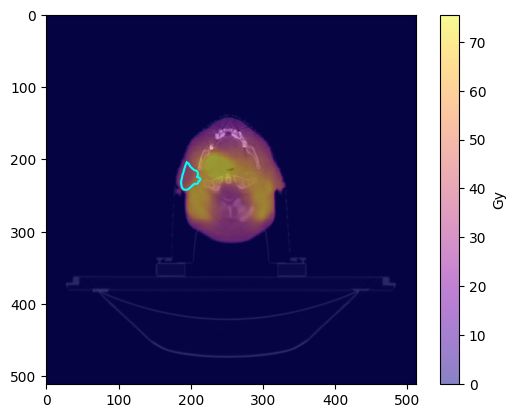

In [49]:
# Veryfy with CT
plt.imshow(slices[slice_num].pixel_array,cmap='gray')
plt.imshow(resized_dose_map[slice_num],cmap=plt.cm.plasma,alpha=.5)
plt.plot(roi_x,roi_y,'-',color='cyan',label='Parotid_R')
plt.colorbar(label="Gy")